TODO Poner la cobertura de genes (muy pocos representados en el ME model)


In [1]:
# Energy from the ME model

In [2]:
import re
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from energy_analisis import get_energy_consumption_production, get_energy_per_gene
from plot_energy import plot_ME_energy

In [3]:
# load solved ME model
with open('../files/models/iJL1678b_solver.pickle', 'rb') as f:
    me = pickle.load(f)

# ATP consumption per reaction 

In [4]:
# Get the consumption and production of energy per reaction
reactions_energy_consumption,reactions_energy_production = get_energy_consumption_production(me)

In [5]:
energy_consumption = pd.DataFrame.from_dict(reactions_energy_consumption).set_index('Reactions')
energy_consumption.head()

,Type,Total,Used,ATP
Reactions,,,,
transcription_TU0_8529_from_RpoD_mono,TranscriptionReaction,-347.0,-3.988197e-09,-347.0
transcription_TU0_8464_from_RpoD_mono,TranscriptionReaction,-88.0,-2.039023e-04,-88.0
transcription_TU0_13006_from_RpoD_mono,TranscriptionReaction,-172.0,-5.661036e-12,-172.0
transcription_TU0_5003_from_RPOH_MONOMER,TranscriptionReaction,-434.0,-1.200694e-07,-434.0
transcription_TU0_3423_from_RPOE_MONOMER,TranscriptionReaction,-109.0,-3.812990e-06,-109.0


In [6]:
energy_production = pd.DataFrame.from_dict(reactions_energy_production).set_index('Reactions')
energy_production.head()

,Type,Total,Used,ATP
Reactions,,,,
ATPS4rpp_FWD_ATPSYN-CPLX_mod_mg2,MetabolicReaction,1.0,52.367990,1.0
PGK_REV_PGK-CPLX,MetabolicReaction,1.0,12.566816,1.0
PPK2r_REV_PPK-CPLX,MetabolicReaction,1.0,0.000097,1.0
SUCOAS_REV_SUCCCOASYN,MetabolicReaction,1.0,3.955319,1.0


In [7]:
total_produced = energy_production.sum().Used
total_produced

68.89022155075351

In [8]:
# Save file
energy_consumption.to_pickle('../files/energy/energy_per_reaction.pickle')

In [9]:
with open('../files/energy/energy_per_reaction.pickle', 'rb') as f:
    energy_consumption = pickle.load(f)

In [10]:
energy_consumption.loc[:,'Used'] = abs(energy_consumption.Used)
energy_consumption.head()

,Type,Total,Used,ATP
Reactions,,,,
transcription_TU0_8529_from_RpoD_mono,TranscriptionReaction,-347.0,3.988197e-09,-347.0
transcription_TU0_8464_from_RpoD_mono,TranscriptionReaction,-88.0,2.039023e-04,-88.0
transcription_TU0_13006_from_RpoD_mono,TranscriptionReaction,-172.0,5.661036e-12,-172.0
transcription_TU0_5003_from_RPOH_MONOMER,TranscriptionReaction,-434.0,1.200694e-07,-434.0
transcription_TU0_3423_from_RPOE_MONOMER,TranscriptionReaction,-109.0,3.812990e-06,-109.0


# ATP consumption per gene

In [11]:
total = get_energy_per_gene(energy_consumption, me)

In [12]:
Energia_total_ME = pd.DataFrame(total.items(), columns=['Bnumber', 'Value'])
Energia_total_ME = Energia_total_ME.sort_values(by='Value',ascending=False).reset_index()
Energia_total_ME = Energia_total_ME.loc[:,['Bnumber','Value']]

In [13]:
Energia_total_ME.to_pickle('../files/energy/energy_per_gene.pickle')

In [14]:
Energia_total_ME.head()

,Bnumber,Value
0,b3256,32.329346
1,dummy,1.671482
2,b2752,0.977113
3,b1677,0.232208
4,b0727,0.194296


# ATP consumption (Strains)

In [15]:
names_W3110 = ['DGF298', 'DGF327', 'MGF02', 'MGF01' ]
names_MG1655 = ['Δ16', 'MS56', 'MDS69','MDS42','MDS12']
strains = names_MG1655+names_W3110

genes_finales = {}

for strain in strains:
    genes_finales[strain] = pd.read_csv('../files/deleted_genes/mapped_del_genes_'+strain+'.csv')
    genes_finales[strain] = genes_finales[strain].drop(columns= 'Unnamed: 0')

#### Per gene

In [16]:
strain_energy_per_gen={}
for strain in strains:
    genes = genes_finales[strain].Bnumber
    strain_energy_per_gen[strain] = Energia_total_ME.loc[Energia_total_ME.Bnumber.isin(genes)]

#### Per strain

In [17]:
strain_energy_total={}
for strain in strains:
    strain_energy_total[strain] = [strain_energy_per_gen[strain].Value.sum()]
    
strain_energy_total_per={}
for strain in strains:
    strain_energy_total_per[strain] = [(strain_energy_per_gen[strain].Value.sum()*100)/(total_produced)]

In [18]:
consumo = pd.DataFrame.from_dict(strain_energy_total)
consumo = consumo.T.rename(columns={0:'Energy'}).T
consumo_per =  pd.DataFrame.from_dict(strain_energy_total_per)
consumo_per = consumo_per.T.rename(columns={0:'Energy'}).T

In [19]:
consumo

,Δ16,MS56,MDS69,MDS42,MDS12,DGF298,DGF327,MGF02,MGF01
Energy,0.788286,0.172213,0.167337,0.163238,0.163234,0.174018,0.168425,0.004769,0.003504


In [20]:
relevant_strains = ['Δ16', 'MS56', 'MDS69', 'DGF298', 'MGF02']

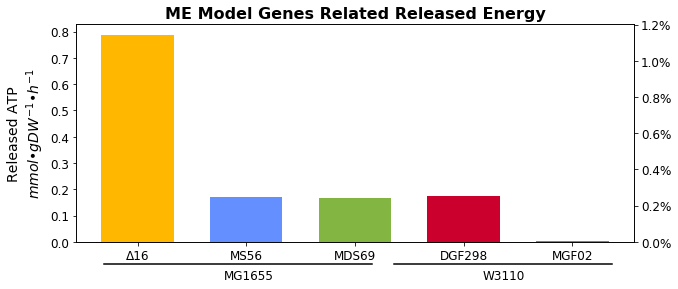

In [21]:
plot_ME_energy(relevant_strains,consumo, consumo_per )

# Energy analysis for each process

#### Replication 

In [22]:
replication_models = ['1', '1.125', '1.25', '1.5']
models = {}

for rep_model in replication_models:
    with open('../files/models/DNA_per'+rep_model+'.pickle', 'rb') as f:
        models[rep_model] = pickle.load(f)

In [23]:
def analisis_energia(modelos):
    production_me = []
    consumption_me = {}
    consumption_perc = [] 

    for modelo in modelos:
        reactions_energy_consumption,reactions_energy_production =get_energy_consumption_production(modelos[modelo])
        #Production
        energy_production = pd.DataFrame.from_dict(reactions_energy_production).set_index('Reactions')
        production_me.append(energy_production.sum().Used)
        #Consumption
        energy_consumption = pd.DataFrame.from_dict(reactions_energy_consumption).set_index('Reactions')
        type_group_consumption = energy_consumption.Used.groupby(energy_consumption.Type)
        consumption_me[modelo]=(abs(type_group_consumption.sum()).sum())
    
    return(consumption_me,production_me)

In [24]:
import seaborn as sns

In [25]:
def plot_glc_ox_atp(consumption_me,modelos):
    ''' Gráfica de consumo de energía con los ejes de consumo de glucosa y oxígeno'''
    
    valores_metabolicos = pd.DataFrame({key:modelos[key].get_metabolic_flux() for key in modelos.keys()})
    glucosa = valores_metabolicos.loc['EX_glc__D_e'].sort_index()*(-1)
    oxigeno = valores_metabolicos.loc['EX_o2_e'].sort_index()*(-1)
    nombres= [nombre.split('me')[1] for nombre in consumption_me.keys()]
    x =  [float(nombre) for nombre in nombres]
    sns.set()
    sns.set_style("ticks")

    fig, ax1 = plt.subplots()

    color = 'tab:red'
    ax1.set_xlabel('UPF',fontsize=16,fontweight='bold')
    ax1.set_ylabel('Consumo de ATP\n $mmol•gDW^{-1}•h^{-1}$', color=color,\
                  fontsize=16,fontweight='bold')

    lb1 = ax1.plot(*zip(*sorted(consumption_me.items())), color=color,marker='o',markersize=8, label = 'ATP')
    ax1.tick_params(axis='x', labelsize=14)
    ax1.tick_params(axis='y', labelcolor=color,labelsize=14)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax2.set_ylabel('Consumo de\noxígeno y glucosa\n $mmol•gDW^{-1}•h^{-1}$', color='black',\
                  fontsize=16,fontweight='bold')  # we already handled the x-label with ax1

    lb2 = ax2.plot(*zip(*glucosa.sort_index().items()), color=color,marker='o',markersize=8, label = 'Glucosa')
    color='tab:green'
    lb3 = ax2.plot(*zip(*oxigeno.sort_index().items()), color=color,marker='o',markersize=8, label = 'Oxígeno')

    ax2.tick_params(axis='y', labelcolor='black')

    # fig.tight_layout()  
    a = plt.xticks()[0]
    plt.xticks(a, [str(nombre) for nombre in sorted(x)])
#     plt.xticks(a, ['0.24','0.27','0.30','0.33','0.36'])
    plt.yticks(fontsize=14)

    leg = lb1 + lb2 + lb3
    labs = [l.get_label() for l in leg]
    ax1.legend(leg, labs,loc='center left', bbox_to_anchor=(1.25, 0.5))
    plt.show()

In [26]:
consumption_me,p = analisis_energia(models)

In [29]:
consumption_me

{'me1': 57.2357657981071,
 'me1.125': 57.205545551383345,
 'me1.25': 57.17532524611092,
 'me1.5': 57.11488484494159}

In [27]:
consumption_me['me1'] = consumption_me.pop('1')
consumption_me['me1.125'] = consumption_me.pop( '1.125')
consumption_me['me1.25'] = consumption_me.pop('1.25')
consumption_me['me1.5'] = consumption_me.pop('1.5')

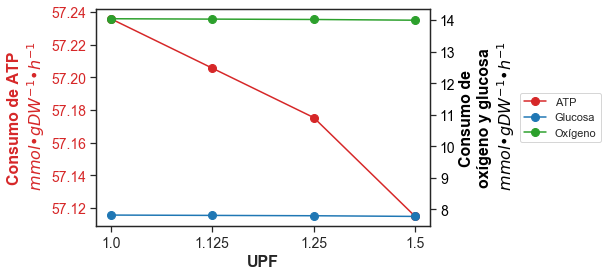

In [28]:
plot_glc_ox_atp(consumption_me, models)

In [33]:
from scipy import stats



In [34]:
valores = [1, 1.125, 1.25, 1.5]
new_valores = np.array(valores)

equivalentes_genoma = new_valores*1.63 
equivalentes_genoma
bp = equivalentes_genoma*4641652/1.63
Mb = bp*1/(1*10**6)

In [35]:
slope, intercept, r_value, p_value, std_err = stats.linregress(Mb, list(consumption_me.values()))

In [36]:
slope

-0.05208531742279945

#### Transcription 